Number of identities: 116
Number of image files: 589
random selected images :  [417, 463, 290, 166]


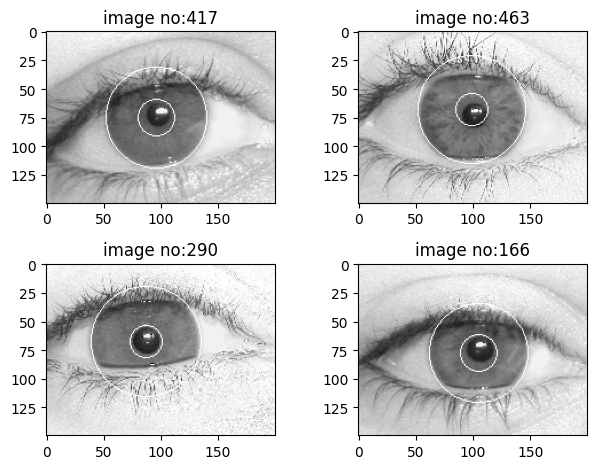

In [12]:
import numpy as np
import skimage
import scipy
import numpy as np
import os
from glob import glob
import random
import matplotlib.pyplot as plt

def find_iris(image):
    
    r_min = 20  # irisin minimum yaricapi
    r_max = 100 # irisin maksimum yaricapi
    threshold = 12 # çember farkının sınır değeri
            
    # iris gozun orta bölgelerinde olduğu için derste söylediğiniz gibi resmi 3 * 3 lük alana bölüp sadece orta
    # karede arama yaptım.
    
    start_index_y = round(image.shape[0] / 3)  # 50
    end_index_y = round(start_index_y + (image.shape[0] / 3))
    start_index_x = round(image.shape[1] / 3)  # 67
    end_index_x =  round(start_index_x + (image.shape[1] / 3))
    
    #merkez olması muhtemel noktalar
    possible_centers_x = []
    possible_centers_y = []
    possible_centers_rad = []
    
    for index_y in range(start_index_y,end_index_y):
        for index_x in range(start_index_x, end_index_x):
            
            sum_area = accumulate_circle(image,index_x,index_y,r_min)
            last_normalized_sum = normalize_accumulation(sum_area, r_min) # initialization for diffential operator
            
            for r in range(r_min, r_max):
                
                sum_area = accumulate_circle(image,index_x,index_y,r)
                normalized_sum = normalize_accumulation(sum_area, r)
               
                if(normalized_sum - last_normalized_sum > threshold) : # burasi gözün merkezi olabilir burdaki yaricapi kaydedelim
                    possible_centers_x.append(index_x)
                    possible_centers_y.append(index_y)
                    possible_centers_rad.append(r)
                        
                last_normalized_sum = normalized_sum
    
    #possible_centers arraylerindeki en büyük yarı çap ve en büyükten 4 piksel küçük yarıçapların
    # x,y lerinin olduğu indexleri kaydedelim.
    
    indices = [index for index, item in enumerate(possible_centers_rad) 
               if (item == max(possible_centers_rad) or item >  max(possible_centers_rad) - 4) ]

    #yukarida kaydettiğimiz indexlerin olduğu x,y ve r değerlerinin ortalamasını alalım, merkez
    # ve yarıcapi elde edelim.
    tmp_x = 0
    tmp_y = 0
    tmp_rad = 0
    for i in indices:
        tmp_x += possible_centers_y[i]
        tmp_y += possible_centers_x[i]
        tmp_rad += possible_centers_rad[i]
    
    mean_value_x = round(tmp_x / len(indices)) 
    mean_value_y = round(tmp_y / len(indices)) 
    mean_value_rad = round(tmp_rad / len(indices)) 
    
    return mean_value_x, mean_value_y, mean_value_rad
    
def find_pupil(image,iris_x,iris_y,iris_rad):
    # irisin merkezini buldugumuza göre goz bebegi için yeni bir merkez araması yapmak yerine o merkezden
    # r_min ve r_max kadar uzaklaşıp göz bebeği araması yaptım.
    
    r_min = round(iris_rad * 0.1)  # pupil'in min yaricapi
    r_max = round(iris_rad * 0.8)  # pupil'in max yaricapi
    threshold = 5 # çember farkının sınır değeri iris ile göz bebeği arasındaki değer 
                  #daha düşük olduğu için thresholdu daha düşük
    
    possible_rads = []
    
    sum_area = accumulate_circle(image,iris_x,iris_y,r_min)
    last_normalized_sum = normalize_accumulation(sum_area, r_min) #baslangic icin
    
    for r in range(r_min, r_max):
        sum_area = accumulate_circle(image,iris_x,iris_y,r)
        normalized_sum = normalize_accumulation(sum_area, r)
        if(normalized_sum - last_normalized_sum > threshold) : # burasi gözün merkezi olabilir burdaki yaricapi kaydedelim
            possible_rads.append(r)
                        
        last_normalized_sum = normalized_sum
        
    tmp_rad = 0
    for rad in possible_rads:
        tmp_rad += rad
    
    mean_value_rad = round(tmp_rad / len(possible_rads))    
    
    return mean_value_rad


def accumulate_circle(image, x, y, r):

    #Merkezi (x, y) ve yarıçapı r olan bir daireyi temsil eden alanı toplayan fonksiyon.
    cy, cx = skimage.draw.circle_perimeter(y, x, r, shape=image.shape)
    area = np.sum(image[cy, cx])
    return area

def normalize_accumulation(accum, r):
    return accum / (2 * np.pi * r) 


if __name__ == "__main__":
    
    # load test images
    dataset_dir = "./Sessao_1"
    
    test_image_count = 4
    identities = glob(os.path.join(dataset_dir, "**"))
    identities = sorted([os.path.basename(identity) for identity in identities])
    n_identities = len(identities)
    N_IMAGES = n_identities
    
    image_files = []
    for identity in identities:
        files = glob(os.path.join(dataset_dir, identity, "*.*"))
        image_files += files[:N_IMAGES]

    n_image_files = len(image_files)
    
    # pick images randomly
    pick_random_images = []
    for i in range(0,test_image_count): # random resim secmek icin sayi uret
        x = random.randint(1,n_image_files)
        pick_random_images.append(x)
    
    print("Number of identities:", n_identities)
    print("Number of image files:", n_image_files)
    print("random selected images : ", pick_random_images)
    
    subplot_index = 1
    for i in pick_random_images :
        
        image =skimage.io.imread(image_files[i])

        iris_x, iris_y, iris_rad = find_iris(image)
        rr, cc = skimage.draw.circle_perimeter(iris_x, iris_y, iris_rad)   #iris çevresine çember ciz
        image[rr, cc] = [255]  # çizgi çiz

        pupil_rad = find_pupil(image,iris_x,iris_y,iris_rad)
        rr, cc = skimage.draw.circle_perimeter(iris_x, iris_y, pupil_rad)   # goz bebegine çember ciz
        image[rr, cc] = [255]  # çizgi çiz
        
        plt.subplot(int(test_image_count/2),int(2),subplot_index)
        plt.imshow(image, cmap='gray', vmin = 0, vmax = 255)
        plt.title("image no:" + str(i))
               
        subplot_index += 1

        
    plt.tight_layout()
    plt.show()
        
        #skimage.io.imshow(image)
        #skimage.io.show()
        #plt.title(image)

Aşağıda bazı kaydedilen çıktılar ve yorumları bulunmaktadir. (NOT: Sisteme yüklemek için 20 mb sınırı olduğu için datasetteki bazı resimleri silerek sisteme yükledim.)

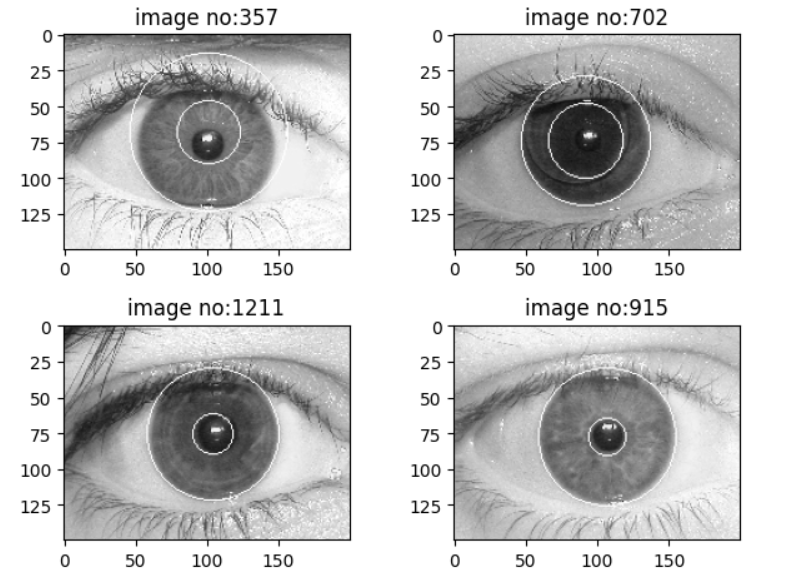

resim 357'deki irisin üst bölgesine kirpiklerin gelmesi sebebiyle diferansiyel operatörü thresholda geç girmiş ve iris çapı bu yüzden büyük çıkmıştır. Ayrıca histogramı incelendiğinde açık değerlere yakın bir resim olduğu gözükmektedir ancak aşağıda histogram eşitlemesi yapıldıktan sonra renk değerlerini birbirine yaklaştırdığımız için daha kötü bir çıktı verdiği tespit edilmiştir.(Aşağıda resim 357'nin histogram eşitlemesi yapıldıktan sonraki çıktısı verilmiştir.)

resim 702'de ise iris çok koyu olduğu için göz aynı 357'deki gibi bir şekilde olmasına rağmen iris koyuluğu gözün beyaz kısmındaki farkın çok çıkmasına sebep olmuş ve çapı olması gerektiği gibi bulmuştur. Bunun yanında göz bebeği ve iris renginin birbirine çok yakın değerlerde olduğu için gözbebeğinin tespitinde zorlanmıştır.

diğer resimler daha temiz bir görüntü sağladığı için algoritma çıktıları kabul edilebilir değerlerdedir.

Text(0.5, 1.0, 'image no:357')

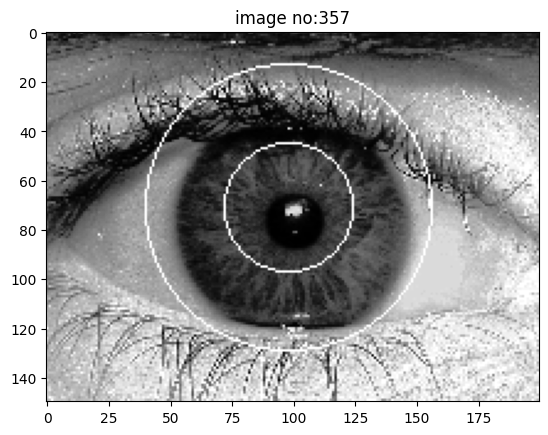

In [36]:
import cv2

image =skimage.io.imread(image_files[357])
hist,bin = np.histogram(image.ravel(),256,[0,255])

image = cv2.equalizeHist(image)

iris_x, iris_y, iris_rad = find_iris(image)
rr, cc = skimage.draw.circle_perimeter(iris_x, iris_y, iris_rad)   #iris çevresine çember ciz
image[rr, cc] = [255]  # çizgi çiz

pupil_rad = find_pupil(image,iris_x,iris_y,iris_rad)
rr, cc = skimage.draw.circle_perimeter(iris_x, iris_y, pupil_rad)   # goz bebegine çember ciz
image[rr, cc] = [255]  # çizgi çiz

plt.imshow(image, cmap='gray', vmin = 0, vmax = 255)
plt.title("image no:" + str(357))


---------------------------------------------------

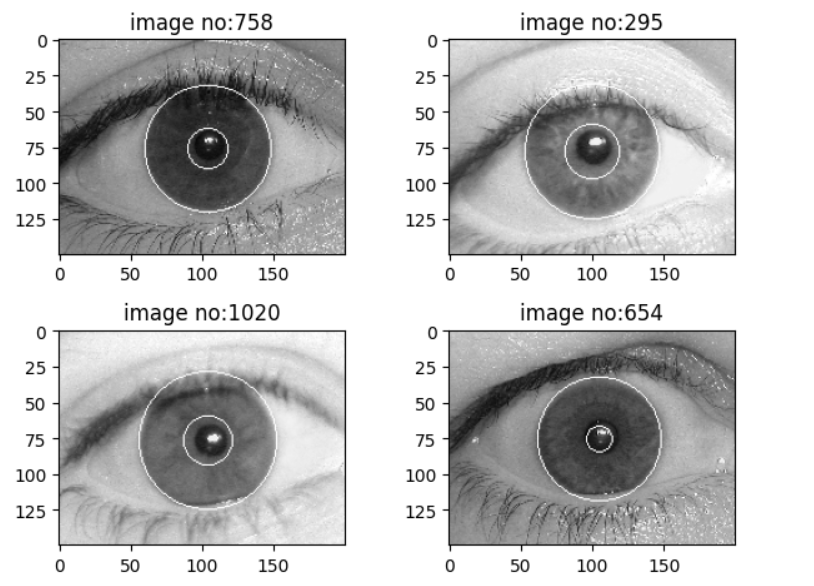

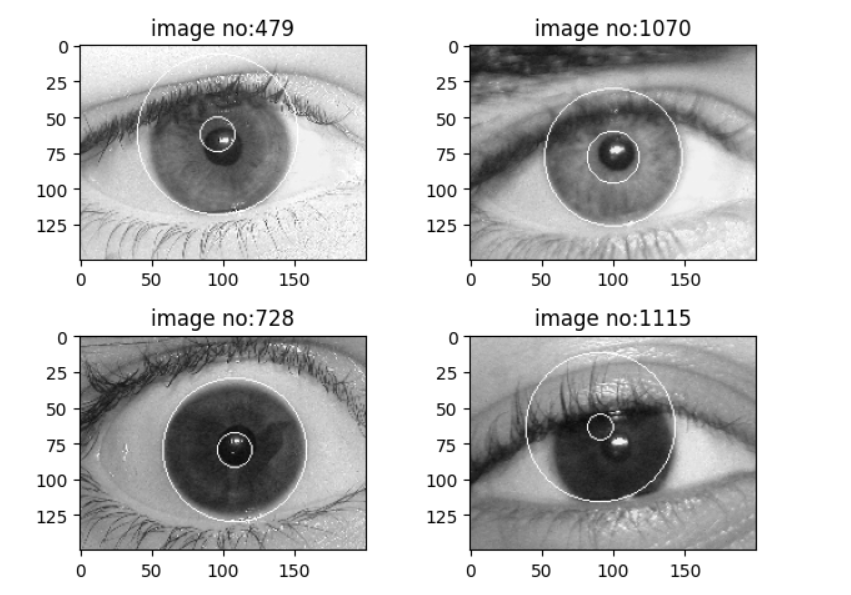

In [ ]:
gözün tamamının çıkmadığı resimlerde tespit hataları büyümektedir. Gözün tam çıkmadığı resimlerde kirpiklerin etkisi
gözle görülmektedir özellikle 1115 numaralı resimde iris merkezini kirpiklerin yoğun olduğu bölgeye kaydırmış ve bu yüzden
göz bebeği tespiti irisin de koyu olması sebebiyle kabul edilemez şekilde hatalı çıkmıştır. Benzer durum 479 numaralı resimde
de vardır ancak göz bebeğinin tespiti iris renginin açık olması sebebiyle bu o kadar hatalı değildir.